# How To Create Your Own Widgets

This notebook provides a simple tutorial on how to create your own Menpo widgets, similar to the ones in _Main Widgets.ipynb_. New Menpo widgets can be synthesized using the components presented in _Widgets Components.ipynb_. So before continuing with this notebook, please go through that one first.

The widget we create here is very simple since the purpose of this tutorial is to provide a basic introduction. The aim of the widget will be to go through a `list` of images and crop them with respect to a proportion of their landmarks. The crop proportion will be controlled by the user using a slider. There will also be some information printing regarding each image's size.

We split the presentation in the following steps:

1. __Import Images__
2. __Required Widgets__
3. __Widgets Grouping and Styling__
4. __Define Render Function__
5. __Final Widget Function__

### 1. Import Images

Firstly, we need to import a `list` of images. Let's import the first 20 images of LFPW's testset and convert them to grayscale.

In [1]:
%matplotlib inline
import menpo.io as mio

path_to_lfpw = '/vol/atlas/databases/lfpw/'

images = []
for i in mio.import_images(path_to_lfpw + 'testset/*', max_images=20, verbose=True):
    # convert it to greyscale if needed
    if i.n_channels == 3:
        i = i.as_greyscale(mode='luminosity')
    # append it to the list
    images.append(i)

Importing assets: [==========] 100% (20/20) - 00:00:00 remaining


:0: FutureWarning: IPython widgets are experimental and may change in the future.


### 2. Required Widgets

We need the `AnimationOptionsWidget` in order to be able to browse through the `list` of images. This takes a `dict` with the initial indexing options. Of course the maximum index value should be equal to the number of loaded images.

In [2]:
from menpo.visualize.widgets import AnimationOptionsWidget
from IPython.display import display

index = {'min': 0, 'max': len(images) - 1, 'step': 1, 'index': 0}

anim_wid = AnimationOptionsWidget(index, description='Image')
display(anim_wid)

We also need a way to define the crop percentage. This can be done with a simple slider that selects `float` numbers and is bounded between `0.0` and `1.0`. Thus

In [3]:
from IPython.html.widgets import FloatSlider

prop_wid = FloatSlider(value=1., min=0., max=1., step=0.1, 
                       description='Proportion:', width='4.5cm')
display(prop_wid)

Moreover, we can also create a `TextPrintWidget` for printing some info regarding the cropped image. For example

In [4]:
from menpo.visualize.widgets import TextPrintWidget

n_lines = 2
text_per_line = ['> Original size: ', '> Final size: ']

txt_wid = TextPrintWidget(n_lines, text_per_line)
display(txt_wid)

### 3. Widgets Grouping and Styling

We now need to group the widgets in a single box. This can be done using IPython's `FlexBox` and `HBox`.

In [5]:
from IPython.html.widgets import FlexBox, HBox

# Create an initial box for the proportion slider and the print info widget
opts_box = HBox(children=[prop_wid, txt_wid], align='center')

# Create the final widget's box
wid = FlexBox(children=[anim_wid, opts_box])

display(wid)

Now we can apply some styling on the final widget

In [6]:
from menpo.visualize.widgets.options import _map_styles_to_hex_colours

# Select some styles
final_widget_style = 'info'
print_widget_style = 'warning'
animation_widget_style = 'danger'

# Apply the selected final widget style
wid.box_style = final_widget_style
wid.border_width = 1
wid.border_color = _map_styles_to_hex_colours(final_widget_style)
wid.border_radius = 10
prop_wid.slider_color = _map_styles_to_hex_colours(final_widget_style)
prop_wid.background_color = _map_styles_to_hex_colours(final_widget_style)

# Apply the selected print text widget style
txt_wid.predefined_style(style=print_widget_style)

# Apply the selected animation options widget style
anim_wid.predefined_style(style=animation_widget_style)
anim_wid.border_radius = 10
anim_wid.border_width = 1
anim_wid.border_color = _map_styles_to_hex_colours(animation_widget_style)

### 4. Define Render Function

The final step is to define the rendering callback function that will get called everytime a widget value is changed. The function needs to get the image index and proportion value, copy the original image, crop it, visualize it and update the printed info. Remember that all funtions that are used as callbacks in IPython widgets need to get two arguments: _name_ and _value_.

In [7]:
from IPython.display import clear_output
from matplotlib.pyplot import show as pltshow

def render_function(name, value):
    # Clear current figure, but wait until the generation of the new data
    # that will be rendered
    clear_output(wait=True)
    
    # Get selected image index
    i = anim_wid.selected_values['index']
    
    # Get selected crop proportion
    prop = prop_wid.value
    
    # Get a copy of the original image
    im_copy = images[i].copy()
    
    # Crop the copied image inplace
    im_copy.crop_to_landmarks_proportion_inplace(prop)
    
    # Visualize it
    im_copy.view_landmarks();
    
    # Update the printed info
    text_per_line = ['> Original size: {}x{}'.format(images[i].height, images[i].width), 
                     '> Final size: {}x{}'.format(im_copy.height, im_copy.width)]
    txt_wid.set_widget_state(n_lines=2, text_per_line=text_per_line)
    
    # Make sure that image gets rendered
    pltshow()

Let's check that it works properly

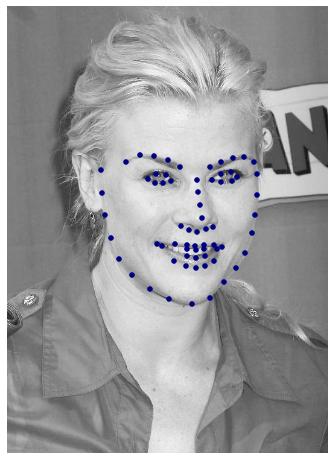

In [8]:
render_function('', 0)

### 5. Final Widget Function

Let's now define a function that summarizes the above steps. It will get as input the images `list` and a `style` argument that can be either `'coloured'` or `'minimal'`.

In [9]:
def crop_images_widget(images, style='coloured'):
    # Create widgets
    index = {'min': 0, 'max': len(images) - 1, 'step': 1, 'index': 0}
    anim_wid = AnimationOptionsWidget(index, description='Image')
    prop_wid = FloatSlider(value=1., min=0., max=1., step=0.1, 
                           description='Proportion:', width='4.5cm')
    text_per_line = ['> Original size: ', '> Final size: ']
    txt_wid = TextPrintWidget(n_lines=len(text_per_line), text_per_line=text_per_line)
    
    # Group widgets
    opts_box = HBox(children=[prop_wid, txt_wid], align='center')
    wid = FlexBox(children=[anim_wid, opts_box])
    
    # Styling
    final_widget_style = ''
    border_width = 0
    print_widget_style = 'minimal'
    animation_widget_style = 'minimal'
    if style == 'coloured':
        final_widget_style = 'info'
        print_widget_style = 'warning'
        animation_widget_style = 'danger'
        border_width = 1
    wid.box_style = final_widget_style
    wid.border_width = border_width
    wid.border_color = _map_styles_to_hex_colours(final_widget_style)
    wid.border_radius = 10
    prop_wid.slider_color = _map_styles_to_hex_colours(final_widget_style)
    prop_wid.background_color = _map_styles_to_hex_colours(final_widget_style)
    txt_wid.predefined_style(style=print_widget_style)
    anim_wid.predefined_style(style=animation_widget_style)
    anim_wid.border_radius = 10
    anim_wid.border_width = border_width
    anim_wid.border_color = _map_styles_to_hex_colours(animation_widget_style)
    
    # Define render function
    def render_function(name, value):
        clear_output(wait=True)
        i = anim_wid.selected_values['index']
        prop = prop_wid.value
        im_copy = images[i].copy()
        im_copy.crop_to_landmarks_proportion_inplace(prop)
        im_copy.view_landmarks();
        pltshow()
        text_per_line = ['> Original size: {}x{}'.format(images[i].height, images[i].width), 
                         '> Final size: {}x{}'.format(im_copy.height, im_copy.width)]
        txt_wid.set_widget_state(n_lines=2, text_per_line=text_per_line)
        
    # Add render_function to the animation widget
    anim_wid.add_render_function(render_function)
    
    # Assign render_function to the proportion slider's value trait
    prop_wid.on_trait_change(render_function, 'value')
    
    # Display the widget
    display(wid)
    
    # Trigger its initial rendering
    render_function(0, '')

That's it! Let's see what we designed!

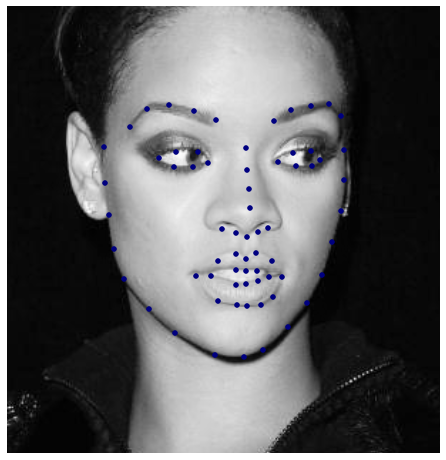

In [10]:
crop_images_widget(images, style='coloured')